#### <b>Download the Dataset</b>

* The dataset contains approximately 13,000 Korean "human face" images.
* In this dataset, all faces are cropped to a resolution of 128 X 128 pixels, although some of the original images have been high resolution.
* Each image filename indicates which family (household) number it belongs to.

In [ ]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbMhBPnmIb5MutZvGicPKggBWKm5hLs0iwKfGW7_TwQIKg?download=1 -O custom_korean_family_dataset_resolution_128.zip
!unzip custom_korean_family_dataset_resolution_128.zip -d ./custom_korean_family_dataset_resolution_128

#### <b>Load Libraries</b>

* Load various useful python libraries for the experiments.

In [1]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection

#### <b>Family Relationship Dataset</b>

1. It consists of a total of 900 households and approximately exact 13,068 individuals.
2. The last part of the filename, such as "a1", indicates the "age group".
  * This dataset consists of 8 age group classes.
  * The task is one of the 8-classes classification problem.
  * If we perform random guessing, the accuracy is approximately 12.5%.
3. The age classification problem is somewhat challenging, thus, we expect that our dataset will be helpful for evaluating the forgetting performance of a machine unlearning algorithm.
  * Our proposed setting has been configured in a way that is almost similar to the NeurIPS Kaggle Competition 2023 held on Kaggle.
4. We have utilized "Family Relationship Dataset" from AI Hub for constructing this dataset.
  * <b>Link</b>: https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=realm&dataSetSn=528

#### <b>Load Datasets</b>

* The following three datasets do not overlap at the household level.
  * Thus, our setting ensures any individual "subjects" are overlapped across the following three sub-dataset.
  * In other wrods, we set any person (subject) to do not simultaneously belonging to the $\mathcal{D}_{train}$, $\mathcal{D}_{test}$ and $\mathcal{D}_{unseen}$.
* <b>Training dataset $\mathcal{D}_{train}$</b>: (F0001 ~ F0299) folders have 10,025 images.
* <b>Test dataset $\mathcal{D}_{test}$</b>: (F0801 ~ F0850) folders have 1,539 images.
* <b>Unseen dataset $\mathcal{D}_{unseen}$</b>: (F0851 ~ F0900) folders have 1,504 images.

In [2]:
"""
> [Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg"] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg"] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg"] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg"] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg"] = "b"
...
"""
def parsing(meta_data):
    image_age_list = []
    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

In [3]:
class Dataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None, forget=False, retain=False):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # Process the metadata.
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

        # After training the original model, we will do "machine unlearning".
        # The machine unlearning requires two datasets, ① forget dataset and ② retain dataset.
        # In this experiment, we set the first 1,500 images to be forgotten and the rest images to be retained.
        if forget:
            self.image_age_list = self.image_age_list[:1500]
        if retain:
            self.image_age_list = self.image_age_list[1500:]

    def __len__(self):
        return len(self.image_age_list)

    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

train_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_128/train_images"

test_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_val_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./custom_korean_family_dataset_resolution_128/val_images"

unseen_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"
unseen_meta_data = pd.read_csv(unseen_meta_data_path)
unseen_image_directory = "./custom_korean_family_dataset_resolution_128/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_dataset = Dataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = Dataset(test_meta_data, test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

unseen_dataset = Dataset(unseen_meta_data, unseen_image_directory, unseen_transform)
unseen_dataloader = DataLoader(unseen_dataset, batch_size=64, shuffle=False)

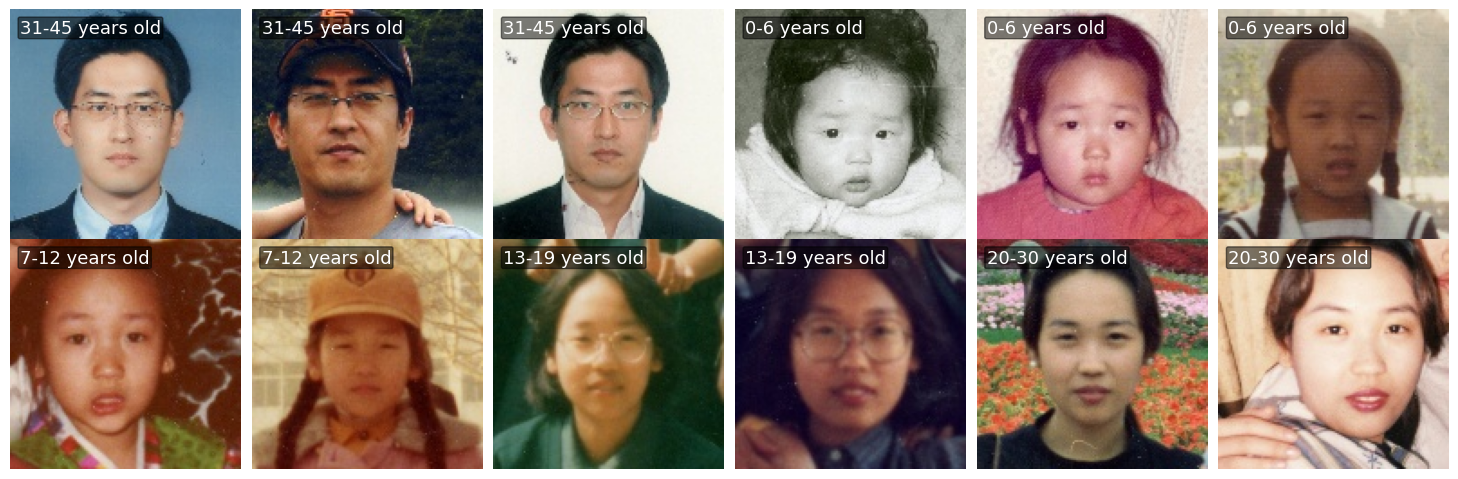

In [5]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

iterator = iter(test_dataloader)
imgs, labels = next(iterator)

label_strs = [label_to_age[label.item()] for label in labels[7:19]]

show_images(imgs[7:19], label_strs, nrow=6)

In [6]:
@torch.no_grad()
def evaluation(model, data_loader):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    running_top2_corrects = 0
    log_step = 20

    for i, batch in enumerate(data_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)  # Get the top 2 class indices.
            top2_correct = top2_preds.eq(labels.view(-1, 1).expand_as(top2_preds))
            running_top2_corrects += top2_correct.any(dim=1).sum().item()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}, running top-2 accuracy: {running_top2_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}, top-2 accuracy: {running_top2_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return {'Loss': running_loss / total, 'Acc': running_corrects / total, 'Top-2 Acc': running_top2_corrects / total}

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [7]:
def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, y in loader:
        targets = y
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = net(inputs)

        losses = criterion(logits, targets).cpu().detach().numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def cal_mia(model):
    set_seed(42)

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}

#### <b>Load the Pre-trained Original Model</b>

* We can easily download the pre-trained original model, rather than training the original model from scratch.
* <b>Download Link</b>: https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfNlaO0X8_1Ij4WPPLs09cgBQl3WB_y7zNTNwvRvIn2CDg

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfNlaO0X8_1Ij4WPPLs09cgBQl3WB_y7zNTNwvRvIn2CDg?download=1 -O pre_trained_last_checkpoint_epoch_30.pth

--2023-10-30 17:21:26--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfNlaO0X8_1Ij4WPPLs09cgBQl3WB_y7zNTNwvRvIn2CDg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/Machine%20Unlearning/last_checkpoint_epoch_30.pth?ga=1 [following]
--2023-10-30 17:21:27--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/Machine%20Unlearning/last_checkpoint_epoch_30.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 44803358 (43M) [application/octet-stream]
Saving to: ‘pre_trained_last_checkpoint_epoch_30.pth’

pre_trained_last_ch 10

#### <b>Machine Unlearning Experiments</b>

* In the NeurIPS Competition setting, when performing machine unlearning, training is done with 'retain' and 'forget', so augmentation can be applied. However, it should never be applied during evaluation.
* We divide training dataset $\mathcal{D}_{train}$ into a retain dataset $\mathcal{D}_{retain}$ and a forget dataset $\mathcal{D}_{forget}$.

In [8]:
forget_dataset_train = Dataset(train_meta_data, train_image_directory, train_transform, forget=True)
forget_dataloader_train = DataLoader(forget_dataset_train, batch_size=64, shuffle=True)

retain_dataset_train = Dataset(train_meta_data, train_image_directory, train_transform, retain=True)
retain_dataloader_train = DataLoader(retain_dataset_train, batch_size=64, shuffle=True)

forget_dataset_test = Dataset(train_meta_data, train_image_directory, test_transform, forget=True)
forget_dataloader_test = DataLoader(forget_dataset_test, batch_size=64, shuffle=False)

retain_dataset_test = Dataset(train_meta_data, train_image_directory, test_transform, retain=True)
retain_dataloader_test = DataLoader(retain_dataset_test, batch_size=64, shuffle=False)

In [9]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Forget dataset size:', len(forget_dataset_train))
print('Retain dataset size:', len(retain_dataset_train))
print('Unseen dataset size:', len(unseen_dataset))

Train dataset size: 10025
Test dataset size: 1539
Forget dataset size: 1500
Retain dataset size: 8525
Unseen dataset size: 1504


In [10]:
# Checking for duplicates across datasets
train_image_paths = [x[0] for x in train_dataset.image_age_list]
test_image_paths = [x[0] for x in test_dataset.image_age_list]
forget_image_paths = [x[0] for x in forget_dataset_train.image_age_list]
retain_image_paths = [x[0] for x in retain_dataset_train.image_age_list]
unseen_image_paths = [x[0] for x in unseen_dataset.image_age_list]

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retain': test_retain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retain_unseen': retain_unseen_overlap
}
overlap_dict

{'train_test': 0,
 'train_forget': 1500,
 'train_retain': 8525,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retain': 0,
 'test_unseen': 0,
 'forget_retain': 0,
 'forget_unseen': 0,
 'retain_unseen': 0}

<b>Original Model Preformance</b>

In [11]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
original_model = models.resnet18(pretrained=False)
num_features = original_model.fc.in_features
original_model.fc = nn.Linear(num_features, 8)
original_model.load_state_dict(torch.load(original_save_path))
original_model = original_model.cuda()
criterion = nn.CrossEntropyLoss()

test_acc = evaluation(original_model, test_dataloader)
test_acc

set_seed(42)

# Performance
test_acc = evaluation(original_model, test_dataloader)
unseen_acc = evaluation(original_model, unseen_dataloader)
mia = cal_mia(original_model.cuda())
print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.023255331441760063, running test accuracy: 0.65625, running top-2 accuracy: 0.9375
[Batch: 20] running test loss: 0.02429156699217856, running test accuracy: 0.6015625, running top-2 accuracy: 0.88359375
test loss: 0.02677902813620812, accuracy: 0.5951916829109811, top-2 accuracy: 0.8804418453541261
elapsed time: 2.8723092079162598
[Test]
[Batch: 1] running test loss: 0.023255331441760063, running test accuracy: 0.65625, running top-2 accuracy: 0.9375
[Batch: 20] running test loss: 0.02429156699217856, running test accuracy: 0.6015625, running top-2 accuracy: 0.88359375
test loss: 0.02677902813620812, accuracy: 0.5951916829109811, top-2 accuracy: 0.8804418453541261
elapsed time: 1.3082733154296875
[Test]
[Batch: 1] running test loss: 0.01937253773212433, running test accuracy: 0.640625, running top-2 accuracy: 0.9375
[Batch: 20] running test loss: 0.02052664360962808, running test accuracy: 0.65703125, running top-2 accuracy: 0.89609375
test loss:

#### <b>Fine-Tuning</b>
* A method where the original model undergoes further training solely on the retain dataset.
* This approach aims to reinforce the model's knowledge of the retain dataset, potentially leading to the forgetting of the previously learned forget dataset.

In [12]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 8)
unlearned_model.load_state_dict(torch.load(original_save_path))
unlearned_model = unlearned_model.cuda()
criterion = nn.CrossEntropyLoss()

test_acc = evaluation(unlearned_model, test_dataloader)
test_acc

[Test]
[Batch: 1] running test loss: 0.023255331441760063, running test accuracy: 0.65625, running top-2 accuracy: 0.9375
[Batch: 20] running test loss: 0.02429156699217856, running test accuracy: 0.6015625, running top-2 accuracy: 0.88359375
test loss: 0.02677902813620812, accuracy: 0.5951916829109811, top-2 accuracy: 0.8804418453541261
elapsed time: 1.3103716373443604


{'Loss': 0.02677902813620812,
 'Acc': 0.5951916829109811,
 'Top-2 Acc': 0.8804418453541261}

In [13]:
set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()

        # Classification Loss
        outputs_retain = unlearned_model(x_retain.cuda())
        classification_loss = criterion(outputs_retain, y_retain)

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()

        running_loss += classification_loss.item() * x_retain.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")

Epoch [1/2], Batch [1/134] - Batch Loss: 0.0684
Epoch [1/2], Batch [2/134] - Batch Loss: 0.0694
Epoch [1/2], Batch [3/134] - Batch Loss: 0.1521
Epoch [1/2], Batch [4/134] - Batch Loss: 0.0999
Epoch [1/2], Batch [5/134] - Batch Loss: 0.1253
Epoch [1/2], Batch [6/134] - Batch Loss: 0.0666
Epoch [1/2], Batch [7/134] - Batch Loss: 0.1253
Epoch [1/2], Batch [8/134] - Batch Loss: 0.1272
Epoch [1/2], Batch [9/134] - Batch Loss: 0.1677
Epoch [1/2], Batch [10/134] - Batch Loss: 0.0695
Epoch [1/2], Batch [11/134] - Batch Loss: 0.0952
Epoch [1/2], Batch [12/134] - Batch Loss: 0.1777
Epoch [1/2], Batch [13/134] - Batch Loss: 0.0589
Epoch [1/2], Batch [14/134] - Batch Loss: 0.1540
Epoch [1/2], Batch [15/134] - Batch Loss: 0.0835
Epoch [1/2], Batch [16/134] - Batch Loss: 0.1534
Epoch [1/2], Batch [17/134] - Batch Loss: 0.1022
Epoch [1/2], Batch [18/134] - Batch Loss: 0.0360
Epoch [1/2], Batch [19/134] - Batch Loss: 0.0992
Epoch [1/2], Batch [20/134] - Batch Loss: 0.0553
Epoch [1/2], Batch [21/134] -

In [14]:
# Performance
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.023728128522634506, running test accuracy: 0.671875, running top-2 accuracy: 0.9375
[Batch: 20] running test loss: 0.025391544122248887, running test accuracy: 0.61171875, running top-2 accuracy: 0.89140625
test loss: 0.028049036850783637, accuracy: 0.6055880441845354, top-2 accuracy: 0.8882391163092918
elapsed time: 1.3119471073150635
[Test]
[Batch: 1] running test loss: 0.019499219954013824, running test accuracy: 0.703125, running top-2 accuracy: 0.953125
[Batch: 20] running test loss: 0.021542201517149806, running test accuracy: 0.65, running top-2 accuracy: 0.89375
test loss: 0.022524779345443908, accuracy: 0.6529255319148937, top-2 accuracy: 0.8922872340425532
elapsed time: 1.2801735401153564

Test Acc: {'Loss': 0.028049036850783637, 'Acc': 0.6055880441845354, 'Top-2 Acc': 0.8882391163092918}
Unseen Acc: {'Loss': 0.022524779345443908, 'Acc': 0.6529255319148937, 'Top-2 Acc': 0.8922872340425532}
MIA: {'MIA': 0.7126245847176079, 'Forgeting Scor

#### <b>CF-k (Class-wise Forgetting)</b>
* A strategy that fine-tunes specific layers to make the model forget target data while retaining class structures.

In [15]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 8)
unlearned_model.load_state_dict(torch.load(original_save_path))
cf_model = unlearned_model.cuda()
criterion = nn.CrossEntropyLoss()

In [16]:
# Print a weight set of a front layer in the network to check the freezing.
print(unlearned_model.layer1[0].conv1.weight[0][0])

tensor([[ 0.0823, -0.0807, -0.0291],
        [-0.0787, -0.8153, -0.2380],
        [ 0.0615, -0.1015, -0.0267]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [17]:
set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, unlearned_model.parameters()), lr=0.001)

# Freeze all the parameters.
for param in unlearned_model.parameters():
    param.requires_grad = False

# Only unfreeze the last three layers for the fine-tuning.
for param in unlearned_model.layer3.parameters():
    param.requires_grad = True
for param in unlearned_model.layer4.parameters():
    param.requires_grad = True
for param in unlearned_model.avgpool.parameters():
    param.requires_grad = True
for param in unlearned_model.fc.parameters():
    param.requires_grad = True

num_epochs = 2

for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()

        # Classification Loss
        outputs_retain = unlearned_model(x_retain.cuda())
        classification_loss = criterion(outputs_retain, y_retain)

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()

        running_loss += classification_loss.item() * x_retain.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")

Epoch [1/2], Batch [1/134] - Batch Loss: 0.0954
Epoch [1/2], Batch [2/134] - Batch Loss: 0.1448
Epoch [1/2], Batch [3/134] - Batch Loss: 0.1909
Epoch [1/2], Batch [4/134] - Batch Loss: 0.1117
Epoch [1/2], Batch [5/134] - Batch Loss: 0.0977
Epoch [1/2], Batch [6/134] - Batch Loss: 0.0906
Epoch [1/2], Batch [7/134] - Batch Loss: 0.1673
Epoch [1/2], Batch [8/134] - Batch Loss: 0.1456
Epoch [1/2], Batch [9/134] - Batch Loss: 0.1952
Epoch [1/2], Batch [10/134] - Batch Loss: 0.0871
Epoch [1/2], Batch [11/134] - Batch Loss: 0.1243
Epoch [1/2], Batch [12/134] - Batch Loss: 0.1583
Epoch [1/2], Batch [13/134] - Batch Loss: 0.1031
Epoch [1/2], Batch [14/134] - Batch Loss: 0.2185
Epoch [1/2], Batch [15/134] - Batch Loss: 0.0997
Epoch [1/2], Batch [16/134] - Batch Loss: 0.1709
Epoch [1/2], Batch [17/134] - Batch Loss: 0.1442
Epoch [1/2], Batch [18/134] - Batch Loss: 0.0441
Epoch [1/2], Batch [19/134] - Batch Loss: 0.0921
Epoch [1/2], Batch [20/134] - Batch Loss: 0.0567
Epoch [1/2], Batch [21/134] -

In [18]:
# Performance
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.024214962497353554, running test accuracy: 0.625, running top-2 accuracy: 0.921875
[Batch: 20] running test loss: 0.024953809659928085, running test accuracy: 0.59609375, running top-2 accuracy: 0.8828125
test loss: 0.0276154750659142, accuracy: 0.589993502274204, top-2 accuracy: 0.8804418453541261
elapsed time: 1.39316987991333
[Test]
[Batch: 1] running test loss: 0.01942582055926323, running test accuracy: 0.65625, running top-2 accuracy: 0.9375
[Batch: 20] running test loss: 0.020945387706160546, running test accuracy: 0.65546875, running top-2 accuracy: 0.89296875
test loss: 0.02191088970829832, accuracy: 0.6575797872340425, top-2 accuracy: 0.8916223404255319
elapsed time: 1.3203353881835938
Test Acc: {'Loss': 0.0276154750659142, 'Acc': 0.589993502274204, 'Top-2 Acc': 0.8804418453541261}
Unseen Acc: {'Loss': 0.02191088970829832, 'Acc': 0.6575797872340425, 'Top-2 Acc': 0.8916223404255319}
MIA: {'MIA': 0.7126245847176079, 'Forgeting Score': 0.21

In [19]:
# Print a weight set of a front layer in the network to check the freezing.
print(unlearned_model.layer1[0].conv1.weight[0][0])

tensor([[ 0.0823, -0.0807, -0.0291],
        [-0.0787, -0.8153, -0.2380],
        [ 0.0615, -0.1015, -0.0267]], device='cuda:0')
